In [1]:
# Setup: select uncertainty measures and in-distribution dataset
import os
import json
import numpy as np
import pandas as pd
import torch
from collections import defaultdict
from typing import List, Dict

import sys
sys.path.insert(0, '../')
from mdu.eval.eval_utils import load_pickle
from mdu.data.constants import DatasetName
from mdu.data.data_utils import split_dataset_indices
from mdu.unc.constants import VectorQuantileModel
from mdu.unc.multidimensional_uncertainty import MultiDimensionalUncertainty
from mdu.randomness import set_all_seeds

# Optional plotting deps
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Reproducibility
seed = 42
set_all_seeds(seed)

# Choose your measures: import any preset from configs like in main_images_ood.py
from configs.uncertainty_measures_configs import (
    ADDITIVE_TOTALS,
    BAYES_RISK_AND_BAYES_RISK,
    EXCESSES_DIFFERENT_INSTANTIATIONS,
    EXCESSES_DIFFERENT_APPROXIMATIONS_LOGSCORE,
    EXCESSES_DIFFERENT_APPROXIMATIONS_BRIERSCORE,
    EXCESSES_DIFFERENT_APPROXIMATIONS_SPHERICALSCORE,
    EXCESSES_DIFFERENT_APPROXIMATIONS_ZERO_ONE_SCORE,
    BAYES_DIFFERENT_APPROXIMATIONS,
    SINGLE_MEASURE,
)

# === USER CONFIGURATION ===
# Pick which list of uncertainty measures to use
UNCERTAINTY_MEASURES = EXCESSES_DIFFERENT_APPROXIMATIONS_LOGSCORE  # change as desired

# Pick in-distribution dataset to evaluate
IND_DATASET = DatasetName.CIFAR10.value  # change as desired

# Multidimensional model and its params (mirrors main_images_ood.py defaults)
MULTIDIM_MODEL = VectorQuantileModel.ENTROPIC_OT

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if MULTIDIM_MODEL == VectorQuantileModel.CPFLOW:
    train_kwargs = {"lr": 1e-4, "num_epochs": 10, "batch_size": 64, "device": device}
    multidim_params = {
        "feature_dimension": len(UNCERTAINTY_MEASURES),
        "hidden_dim": 8,
        "num_hidden_layers": 5,
        "nblocks": 4,
        "zero_softplus": False,
        "softplus_type": "softplus",
        "symm_act_first": False,
    }
elif MULTIDIM_MODEL == VectorQuantileModel.OTCP:
    train_kwargs = {"batch_size": 64, "device": device}
    multidim_params = {"positive": True}
elif MULTIDIM_MODEL == VectorQuantileModel.ENTROPIC_OT:
    train_kwargs = {"batch_size": 64, "device": device}
    multidim_params = {
        "target": "exp",
        "standardize": False,
        "fit_mse_params": False,
        "eps": 0.1,
        "max_iters": 100,
        "tol": 1e-6,
        "random_state": seed,
    }
else:
    raise ValueError(f"Invalid multidim model: {MULTIDIM_MODEL}")

# Ensemble groups (same as scripts)
ENSEMBLE_GROUPS = [
    [0, 1, 2, 3, 4],
    [5, 6, 7, 8, 9],
    [10, 11, 12, 13, 14],
    [15, 16, 17, 18, 19],
]

print(f"Device: {device}")
print(f"Using {len(UNCERTAINTY_MEASURES)} measures: {[m['print_name'] for m in UNCERTAINTY_MEASURES]}")
print(f"In-distribution dataset: {IND_DATASET}")


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All seeds have been set to 42
Device: cuda:0
Using 5 measures: ['EXC 1 1', 'EXC 2 1', 'EXC 1 2', 'EXC 1 3', 'EXC 3 1']
In-distribution dataset: cifar10


In [2]:
# Helpers: discover OOD datasets and run evaluations via main_images_ood.main
from pathlib import Path
from typing import Tuple
from main_images_ood import main as run_one_ood

WEIGHTS_ROOT = Path("../model_weights")


def evaluate_across_oods(
    ensemble_groups: list,
    ind_dataset: str,
    ood_datasets: List[str],
    uncertainty_measures: list,
    multidim_model: VectorQuantileModel,
    multidim_params: dict,
    train_kwargs: dict,
    weights_root: str,
) -> pd.DataFrame:
    dfs = []
    for ood in ood_datasets:
        print(f"Running OOD evaluation: {ind_dataset} -> {ood}")
        df = run_one_ood(
            ensemble_groups,
            ind_dataset,
            ood,
            uncertainty_measures,
            multidim_model,
            multidim_params,
            train_kwargs,
            weights_root,
        )
        dfs.append(df)
    if len(dfs) == 0:
        return pd.DataFrame(columns=[
            "In-distribution","Out-of-distribution","Metric","ROC AUC Scores","Mean ROC AUC","Std ROC AUC"
        ])
    return pd.concat(dfs, ignore_index=True)


All seeds have been set to 42


In [3]:
# Discover OOD datasets and run
available_oods = [DatasetName.CIFAR100.value, DatasetName.SVHN.value, DatasetName.TINY_IMAGENET.value, DatasetName.CIFAR10C_5.value]
print(f"Available OOD datasets for {IND_DATASET}: {available_oods}")

results_df = evaluate_across_oods(
    ENSEMBLE_GROUPS,
    IND_DATASET,
    available_oods,
    UNCERTAINTY_MEASURES,
    MULTIDIM_MODEL,
    multidim_params,
    train_kwargs,
    WEIGHTS_ROOT,
)

print("\nSummary of ROC AUCs across groups and OOD datasets:")
print(results_df)



Available OOD datasets for cifar10: ['cifar100', 'svhn', 'tiny_imagenet', 'cifar10c_5']
Running OOD evaluation: cifar10 -> cifar100


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. Y

train_cond_idx.shape: (1000,)
calib_idx.shape: (1800,)
test_idx.shape: (7200,)
For metrics: ['EXC 1 1', 'EXC 2 1', 'EXC 1 2', 'EXC 1 3', 'EXC 3 1']
Running OOD evaluation: cifar10 -> svhn


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. Y

train_cond_idx.shape: (1000,)
calib_idx.shape: (1800,)
test_idx.shape: (7200,)
For metrics: ['EXC 1 1', 'EXC 2 1', 'EXC 1 2', 'EXC 1 3', 'EXC 3 1']
Running OOD evaluation: cifar10 -> tiny_imagenet


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. Y

train_cond_idx.shape: (1000,)
calib_idx.shape: (1800,)
test_idx.shape: (7200,)
For metrics: ['EXC 1 1', 'EXC 2 1', 'EXC 1 2', 'EXC 1 3', 'EXC 3 1']
Running OOD evaluation: cifar10 -> cifar10c_5


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. Y

train_cond_idx.shape: (1000,)
calib_idx.shape: (1800,)
test_idx.shape: (7200,)
For metrics: ['EXC 1 1', 'EXC 2 1', 'EXC 1 2', 'EXC 1 3', 'EXC 3 1']

Summary of ROC AUCs across groups and OOD datasets:
   In-distribution Out-of-distribution           Metric  \
0          cifar10            cifar100          EXC 1 1   
1          cifar10            cifar100          EXC 2 1   
2          cifar10            cifar100          EXC 1 2   
3          cifar10            cifar100          EXC 1 3   
4          cifar10            cifar100          EXC 3 1   
5          cifar10            cifar100  multidim_scores   
6          cifar10                svhn          EXC 1 1   
7          cifar10                svhn          EXC 2 1   
8          cifar10                svhn          EXC 1 2   
9          cifar10                svhn          EXC 1 3   
10         cifar10                svhn          EXC 3 1   
11         cifar10                svhn  multidim_scores   
12         cifar10       tiny_im

In [ ]:
# Save results to CSV
output_filename = f"pareto_front_results_{IND_DATASET}.csv"
results_df.to_csv(output_filename, index=False)
print(f"Results saved to {output_filename}")

Results saved to pareto_front_results_cifar10.csv


In [5]:
results_df

,In-distribution,Out-of-distribution,Metric,ROC AUC Scores,Mean ROC AUC,Std ROC AUC
0,cifar10,cifar100,EXC 1 1,"[0.9048780277777778, 0.9046918055555555, 0.905...",0.904730,0.000291
1,cifar10,cifar100,EXC 2 1,"[0.903610826388889, 0.9033771041666666, 0.9036...",0.903442,0.000236
2,cifar10,cifar100,EXC 1 2,"[0.9074422083333333, 0.9071313055555555, 0.907...",0.907203,0.000413
3,cifar10,cifar100,EXC 1 3,"[0.9033671249999999, 0.9022849236111111, 0.902...",0.902604,0.000499
4,cifar10,cifar100,EXC 3 1,"[0.9066561180555556, 0.9067848958333333, 0.907...",0.906725,0.000327
5,cifar10,cifar100,multidim_scores,"[0.9063432638888888, 0.9050765694444445, 0.905...",0.905593,0.000517
6,cifar10,svhn,EXC 1 1,"[0.9497939635192584, 0.9556780543604454, 0.929...",0.942616,0.010506
7,cifar10,svhn,EXC 2 1,"[0.9486852132845045, 0.9542001911109403, 0.927...",0.940879,0.010938
8,cifar10,svhn,EXC 1 2,"[0.9518126195110292, 0.9582493181468961, 0.934...",0.945786,0.009672
9,cifar10,svhn,EXC 1 3,"[0.9479708067634707, 0.9535329807757974, 0.925...",0.939684,0.011429


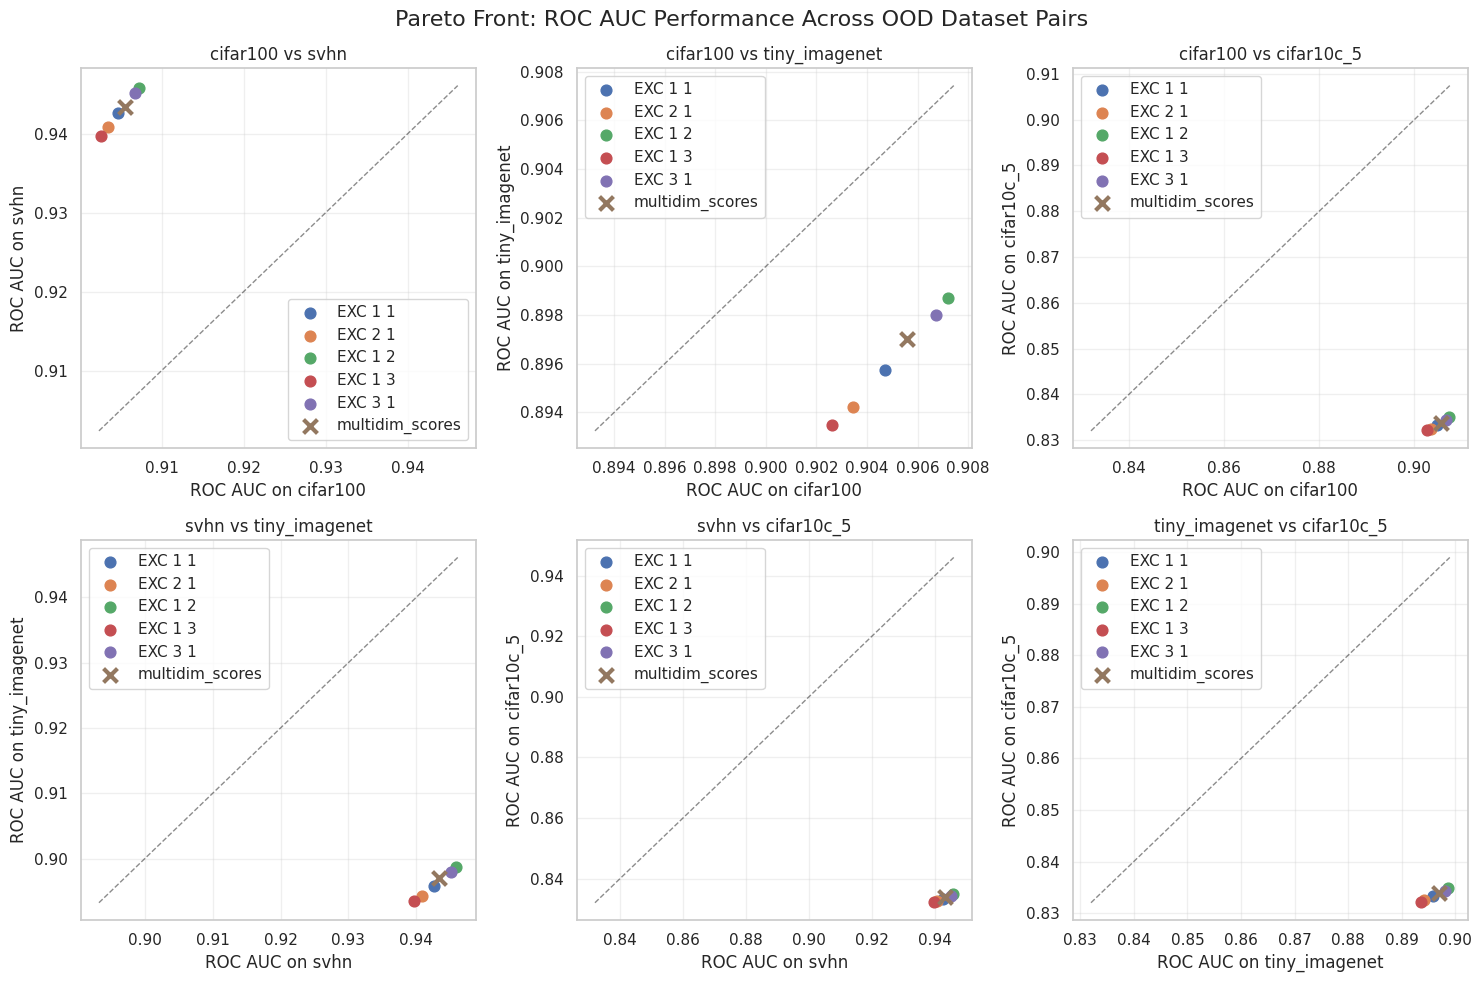

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

# Get unique OOD datasets and metrics
ood_datasets = results_df['Out-of-distribution'].unique()
metrics = results_df['Metric'].unique()

if len(ood_datasets) >= 2:
    # Create scatter plots for all pairs of OOD datasets
    ood_pairs = list(combinations(ood_datasets, 2))
    
    # Calculate subplot dimensions
    n_pairs = len(ood_pairs)
    n_cols = min(3, n_pairs)  # Max 3 columns
    n_rows = (n_pairs + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    
    # Handle case where we have only one subplot
    if n_pairs == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()
    
    for i, (ood1, ood2) in enumerate(ood_pairs):
        ax = axes[i]
        
        # Get data for each OOD dataset
        data_ood1 = results_df[results_df['Out-of-distribution'] == ood1]
        data_ood2 = results_df[results_df['Out-of-distribution'] == ood2]
        
        # Plot each metric
        for metric in metrics:
            # Get ROC AUC for this metric on both OOD datasets
            roc_ood1 = data_ood1[data_ood1['Metric'] == metric]['Mean ROC AUC'].values
            roc_ood2 = data_ood2[data_ood2['Metric'] == metric]['Mean ROC AUC'].values
            
            if len(roc_ood1) > 0 and len(roc_ood2) > 0:
                if metric == 'multidim_scores':
                    # Use cross marker for multidim_scores
                    ax.scatter(roc_ood1[0], roc_ood2[0], marker='x', s=100, label=metric, linewidth=3)
                else:
                    # Use circle marker for other metrics
                    ax.scatter(roc_ood1[0], roc_ood2[0], marker='o', s=60, label=metric)
        
        ax.set_xlabel(f'ROC AUC on {ood1}')
        ax.set_ylabel(f'ROC AUC on {ood2}')
        ax.set_title(f'{ood1} vs {ood2}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add diagonal line for reference
        min_val = min(ax.get_xlim()[0], ax.get_ylim()[0])
        max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=1)
    
    # Hide unused subplots
    for j in range(n_pairs, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Pareto Front: ROC AUC Performance Across OOD Dataset Pairs', fontsize=16)
    plt.tight_layout()
    plt.show()
    
else:
    print(f"Need at least 2 OOD datasets for Pareto front plot. Found: {len(ood_datasets)}")
